# COGS 108 - Final Project 

*Fill in your overview here*

# Names

- Mariam Issa
- Andrea Sudharta
- Payam Sadeghian
- Brandon Amaral
- Alex Luo
- Jun Wang

# Group Members IDs

- A12285140
- A14497101
- A13654507
- A########
- A########
- A15743932

# Research Question

*Fill in your research question here*

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis

*Fill in your hypotheses here*

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name:
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [5]:
import pandas as pd
#import tweepy
from bs4 import BeautifulSoup
import datetime
from datetime import timedelta
import requests
import time

In [6]:
tweeters_dem_df = pd.read_csv('popular-tweeters-dem.csv') #Dataframe for list of Democratic Party politicians
tweeters_rep_df = pd.read_csv('popular-tweeters-rep.csv') #Dataframe for list of Republican Party politicians
tweeters_dem_df['Party'] = 'D'
tweeters_rep_df['Party'] = 'R'
tweeters_df = pd.concat([tweeters_dem_df, tweeters_rep_df], ignore_index = True) # Dataframe for combined list of politicians

tweeters_handle = list(tweeters_df['Twitter_Handle']) #Python list for politician Twitter handles

In [ ]:
# Get OAuth from Twitter
import tweepy

consumer_key = 'bSZRBubFkHWewMi08ltv7DgAu'
consumer_secret = '6JFpZu66GT7OvoJFFxSfJJlX21NH5wxmMjNDbsQGPLyW9WtBSU'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

try:
    redirect_url = auth.get_authorization_url()
    print (redirect_url)
    
except tweepy.TweepError:
    print("Error! Failed to get request token.")

In [ ]:
# Verify Twitter account usage
verifier = raw_input('Verifier:')

In [ ]:
# Get Access Token
try: 
    auth.get_access_token(verifier)
except tweepy.TweepError:
    print ("Error! Failed to get access token.")

In [ ]:
# Save tokens
access_token = auth.access_token
acess_token_secret = auth.access_token_secret

# Note: You do not need to re-fetch it each time. Twitter currently does
# not expire the tokens, so the only time it would ever go invalid is if
# the user revokes our application access. 

#To rebuild an OAuthHandler from the stored access token

# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(key, secret)

In [ ]:
# Check Set Up
api = tweepy.API(auth)
#api.update_status('tweepy + oauth!') # Posts directly on my timeline

In [ ]:
# Filter tweets to only include those containing key words
key_words_by_bill = {
    0:['#savetheinternet', '#netneutrality', 'internet', 'neutrality'], 
    1:['#medicareforall', '#universalhealthcare','#healthcare', 'health', 'care', 'health', 'care', 'medicare'], 
    2: ['#equalpay', '#equalrights', '#equalrightsammendment', '#era', '#women', '#genderinequality', '#genderequality', 'equal', 'rights', 'pay', 'women', 'gender', 'equality'],
    3:['#votingrights', '#votingrightact', '#electionintegrity', '#riggedelections', '#forthepeople', 'voting', 'rights', 'elections', 'fair', 'vote', 'votes'], 
    4:['#guncontrol', '#2ndammendment', '#noguncontol', '#gunviolence', '#gunrights', '#gunreform', '#2a', 'gun', 'second', '2nd',  'amendment'], 
    5:['#yemen', '#yemengenocide', 'yemen', 'yemeni', 'war', 'troops', 'withdraw troops', 'civil'], 
    6:['#women', '#reauthorizationact', '#violenceagainstwomen', '#genderbasedviolence', '#sexualviolence', 'women'],  
    7:['#buildthewall', '#buildthewallnow', '#nationalsecurity', '#nationalemergency', '#trumpswall', '#illegalimmigration', '#mexico', '#border', '#bordercrises', 'mexico', 'illegal', 'immigration', 'security', 'emergency', 'build', 'wall']
}

key_words = list({x for v in key_words_by_bill.itervalues() for x in v})

In [ ]:
# Define Intersection Function
def interSection(arr1,arr2): 
    return list(filter(lambda x: x in arr1, arr2)) 

In [ ]:
# Collect all tweets that deal with each bill in Congress
bill = [{}] * 8 # bill[bill_number] = {congressman: [tweets about bill]}
tweets = {}

In [ ]:
bill_title = {
    0: "Save the Internet",
    1: "Health Care",
    2: "Paycheck Fairness Act",
    3: "For the People Act 2019",
    4: "Background Check for Firearms",
    5: "Remove Troops from Yemen",
    6: "Violence against Women Reauthorization Act",
    7: "Trump's National Emergency"
}

In [ ]:
#Iterate through Congressmen
for handle in tweeters_handle:
    all_tweets = []

    for i in range(1000):
        try:
            tweets_from_page_i = api.user_timeline(handle, count = 200, page = i) # max count value is 200
        except:
            print("TweepError: stopped at handle: ", handle, " at page ", i)
        
        # Check if we reached end of Twitter history
        if len(tweets_from_page_i) == 0: 
            break
            
        #iterate through each tweet, sort by bill
        for tweet in tweets_from_page_i:
            tweet_tokens = (tweet.text).lower().split()
            
            # See if Tweet talks about bill matter
            for bill_number, bill_tokens in key_words_by_bill.items():
                if len(interSection(tweet_tokens, bill_tokens)) != 0:
                    if bill[bill_number] == {}:
                        bill[bill_number] = {handle:[tweet.text]}
                    else:
                        if handle not in bill[bill_number]:
                            bill[bill_number][handle] = [tweet.text]
                        else:
                            bill[bill_number][handle] += [tweet.text]
                    
                    # Compile to all tweets list
                    all_tweets.append(tweet.text)
                    
    # Collect congressman/woman's tweets         
    tweets[handle] = all_tweets
        
    # Sleep: to not overload Twitter requests
    time.sleep(45)

In [ ]:
#Create look up table for Congressman/woman's name and party
tweeters_party = list(tweeters_df['Party'])
tweeters_name = list(tweeters_df['Name'])

handle_to_party = {}
handle_to_name = {}
for i, handle in enumerate(tweeters_handle):
    handle_to_party[handle] = tweeters_party[i]
    handle_to_name[handle] = tweeters_name[i]

data = [] 

# List all tweets by bill it's associated with and the congressman who tweeted it
for i in range(len(bill)):
    for handle, tweet in bill[i].items():
        data.append([handle_to_name[handle], handle_to_party[handle], handle, bill_title[i], tweet])
        
tweeters_df = pd.DataFrame(data, columns = ['Name', 'Party', 'Twitter Handle', 'Bill #', 'Tweet'])

# Export CSV with Tweets
tweeters_df.to_csv('tweets_by_bill')

# Data Cleaning

Describe your data cleaning steps here.

In [ ]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

In [7]:
tweetData = pd.read_csv("tweet_counts.csv")
tweets = pd.read_csv("tweets_by_bill")
tweetData
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

,Name,Background Check for Firearms,For the People Act 2019,Health Care,Paycheck Fairness Act,Remove Troops from Yemen,Save the Internet,Trump's National Emergency,Violence against Women Reauthorization Act
0,Adam Kinzinger,10.0,37.0,39.0,74.0,59.0,2.0,57.0,51.0
1,Adam Schiff,74.0,111.0,49.0,77.0,70.0,9.0,107.0,31.0
2,Adrian Smith,26.0,52.0,159.0,29.0,13.0,1.0,34.0,12.0
3,Alan Lowenthal,76.0,150.0,108.0,138.0,25.0,17.0,85.0,32.0
4,Alexandria Ocasio-Cortez,19.0,108.0,73.0,134.0,19.0,2.0,41.0,61.0
5,Annie Kuster,27.0,102.0,128.0,210.0,19.0,25.0,46.0,144.0
6,Austin Scott,42.0,80.0,86.0,64.0,39.0,3.0,43.0,45.0
7,Barbra Lee,97.0,143.0,166.0,284.0,142.0,20.0,60.0,163.0
8,Barry Loudermilk,20.0,54.0,21.0,39.0,16.0,5.0,71.0,20.0
9,Bill Foster,101.0,140.0,111.0,149.0,23.0,13.0,98.0,79.0


In [9]:
tweets

,Unnamed: 0,Name,Party,Twitter Handle,Bill #,Tweet
0,0,Earl Blumenauer,D,@repblumenauer,Save the Internet,[u'Maintaining a free and open internet is cri...
1,1,Daniel Webster,R,@RepWebster,Save the Internet,"[u'Great to tour @ThatCompanycom, an internet ..."
2,2,John Barrasso,R,@SenJohnBarrasso,Save the Internet,[u'RT @Senate_RPC: [New] The internet thrived ...
3,3,Louie Gohmert,R,@RepLouieGohmert,Save the Internet,"[u'""The bill is referred to as net neutrality ..."
4,4,Steve King,R,@SteveKingIA,Save the Internet,[u'Not one gray head in entire packed gallery ...
5,5,Ted Yoho,R,@RepTedYoho,Save the Internet,[u'RT @HouseGOP: Democrats\u2019 partisan plan...
6,6,Mitch McConnell,R,@senatemajldr,Save the Internet,"[u""RT @CNBC: John Thune: We can't let 'politic..."
7,7,Maxine Waters,D,@RepMaxineWaters,Save the Internet,"[u""RT @freepress: Today at noon, the Voices fo..."
8,8,Terri Sewell,D,@RepTerriSewell,Save the Internet,"[u""I'm proud to vote for the #SaveTheNet Act t..."
9,9,Mo Brooks,R,@RepMoBrooks,Save the Internet,[u'Proud to support passage of #HR3086 to perm...


In [3]:
def party_affiliation(name):
    dems = list(tweeters_dem_df['Name'])
    if name in dems:
        return 'D'
    else:
        return 'R'
tweetData['Party'] = [party_affiliation(rep) for rep in list(tweetData['Name'])]
tweetData

NameError: name 'tweetData' is not defined

In [13]:
votes = pd.read_csv("GovTrack/govtrack.csv")
votes

,state,vote,name,party,Bill
0,OR,1,earl blumenauer,D,Paycheck Fairness Act
1,TX,0,kevin brady,R,Paycheck Fairness Act
2,MD,1,elijah cummings,D,Paycheck Fairness Act
3,CO,1,diana degette,D,Paycheck Fairness Act
4,FL,1,mario diaz-balart,R,Paycheck Fairness Act
5,TX,-1,kay granger,R,Paycheck Fairness Act
6,MD,1,steny hoyer,D,Paycheck Fairness Act
7,OH,1,marcy kaptur,D,Paycheck Fairness Act
8,IA,0,steve king,R,Paycheck Fairness Act
9,GA,1,john lewis,D,Paycheck Fairness Act


In [108]:
(votes['vote']== 1).sum()

D=votes[votes['party'] == "D"]
Inter=D[D['Bill'] == "Trump's National Emergency"]
Inter1=Inter[Inter['vote']==0]
Inter1

,state,vote,name,party,Bill


In [56]:
(D[D['Bill'] == "Health Care"] == 1).count()

state    50
vote     50
name     50
party    50
Bill     50
dtype: int64

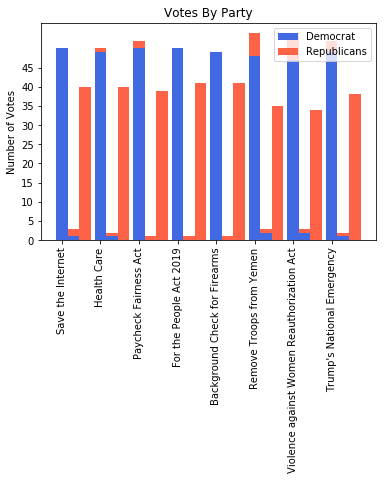

<Figure size 720x720 with 0 Axes>

In [109]:
import numpy as np
import matplotlib.pyplot as plt


N = 8
DemoYes = (50, 49, 50, 50, 49,48,47,49)
RepoYes = (0, 1, 2, 0, 0,6,7,3)
DemoNo = (1,1,0,0,0,2,2,1)
RepoNo = (2,1,1,1,1,1,1,1)
DemoAbstain =(0,0,0,0,0,0,0,0)
RepoAbstain = (40,40,39,41,41,35,34,38)

ind = np.arange(N)    # the x locations for the groups
width = 0.30       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, DemoYes, width, color='royalblue' )
p2 = plt.bar(ind, RepoYes, width,
             bottom=DemoYes, color="tomato" )
p3 = plt.bar(ind +width, DemoNo, width, color='royalblue' )
p4 = plt.bar(ind+width, RepoNo, width,
             bottom=DemoNo, color='tomato' )
p5 = plt.bar(ind +width*2, DemoAbstain, width, color='royalblue' )
p6 = plt.bar(ind+width*2, RepoAbstain, width,
             bottom=DemoAbstain, color='tomato' )



plt.ylabel('Number of Votes')
plt.title('Votes By Party')
plt.xticks(ind, (tweets['Bill #'].unique()),rotation='vertical')
plt.yticks(np.arange(0, 50, 5))
plt.legend((p1[0], p2[0]), ('Democrat', 'Republicans'))

plt.show()
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)



# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*